# TreeDSBM

IMF method for barycentres (not the flow-based method)

applied on MNIST

In [1]:
import os  # before importing anything jax

# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
os.environ['CUDA_VISIBLE_DEVICES']='6'

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from functools import partial

from tqdm import trange
from omegaconf import OmegaConf

from ddpmpp_models.ncsnpp import NCSNpp
from run_BarycentreDSBM import BarycentreDSBM

## plotting fns

In [2]:
def plot_mnist(images, n=10):
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    for i, ax in enumerate(axs):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

## define distributions

In [3]:
images_2s = jnp.load('../data/mnist_2.npy')
images_4s = jnp.load('../data/mnist_4.npy')
images_6s = jnp.load('../data/mnist_6.npy')

images_2s = jnp.transpose(images_2s, (0, 2, 3, 1))
images_4s = jnp.transpose(images_4s, (0, 2, 3, 1))
images_6s = jnp.transpose(images_6s, (0, 2, 3, 1))

class Dist2s:

    @partial(jax.jit, static_argnums=(0,2))
    def sample(self, key, num_samples):
        random_idxs = jax.random.randint(key, (num_samples,), 0, images_2s.shape[0])
        return images_2s[random_idxs]
    
class Dist4s:

    @partial(jax.jit, static_argnums=(0,2))
    def sample(self, key, num_samples):
        random_idxs = jax.random.randint(key, (num_samples,), 0, images_4s.shape[0])
        return images_4s[random_idxs]
    
class Dist6s:

    @partial(jax.jit, static_argnums=(0,2))
    def sample(self, key, num_samples):
        random_idxs = jax.random.randint(key, (num_samples,), 0, images_6s.shape[0])
        return images_6s[random_idxs]

In [4]:
class Gaussian:
    def __init__(self, shape, mean=0.0, std=1.0):
        self.shape = shape
        self.mean = mean * jnp.ones(shape)
        self.std = std

    def sample(self, key, num_samples):
        return jax.random.normal(key, (num_samples,) + self.shape) * self.std + self.mean
    
class t_Dist:
    def sample(self, key, num_samples):
        raise NotImplementedError
    
class UniformDist(t_Dist):
    def sample(self, key, num_samples):
        return jax.random.uniform(key, (num_samples,), minval=0.001, maxval=1.0-0.001)

## define the problem, model

In [5]:
shape = (28,28,1)

epsilon = 0.02 
sigma = jnp.sqrt(epsilon / 2)

mu_0 = Dist2s()
mu_1 = Dist4s()
mu_2 = Dist6s()

mu_lst = [mu_0, mu_1, mu_2]
weights = jnp.array([1.0, 1.0, 1.0])
weights = weights / jnp.sum(weights)

In [6]:
import ml_collections

shape = (28,28,1)

config = ml_collections.ConfigDict()

config.model = model = ml_collections.ConfigDict()

model.nf = 64
model.ch_mult = (1,2,2)
model.num_res_blocks = 2
model.attn_resolutions = (16, 8)
model.dropout = 0.0
model.resamp_with_conv = True
model.conditional = True

model.fir = True
model.fir_kernel = [1, 3, 3, 1]
model.skip_rescale = True
model.resblock_type = "biggan"
model.progressive = "none"
model.progressive_input = "residual"
model.progressive_combine = "sum"
model.attention_type = "ddpm"
model.embedding_type = "fourier"
model.init_scale = 0.0
model.fourier_scale = 16
model.double_heads = False

model.normalization = "GroupNorm"
model.nonlinearity = "swish"

model = NCSNpp(config=config)

params = model.init(jax.random.PRNGKey(0), jnp.ones((1,*shape)), jnp.ones((1,)))
flat_params, _ = jax.flatten_util.ravel_pytree(params)
print("Total number of parameters: ", flat_params.shape)

Total number of parameters:  (6879617,)


## Training

In [7]:
baryDSBM = BarycentreDSBM(
    mu_lst=mu_lst,
    sigma=sigma,
    shape=shape,
    model=model,
)

train_config = OmegaConf.create({
    'num_IMF_steps': 4,
    'num_sampling_steps': 50, #100,
    'num_training_steps': 10_000,
    'reflow_num_training_steps': 2_000,  # number of training steps for reflow (could be lower if desired)
    'num_training_samples': 8_192,      # number of samples to simulate for subsequent IMF iterations
    'lr': 1e-4,
    'batch_size': 64, #64,
    'simulation_batch_size': 1024,      # if num_training_samples is too large, set this to be smaller to simulate in batches
    'ema_rate': 0.001,
    'simultaneous_training': False, #True, #True, #False,
    'warmstart': True,  # True, False, # whether to warmstart the model with the params from the first iteration
})

key = jax.random.PRNGKey(0)
all_states_lst, all_bms_lst = baryDSBM.train(key, train_config=train_config, model=model)

Running IMF step 1


Training: 100%|██████████| 10000/10000 [18:40<00:00,  8.92step/s, loss=107]   


Running IMF step 2


Training: 100%|██████████| 2000/2000 [03:42<00:00,  8.98step/s, loss=643] 


Running IMF step 3


Training: 100%|██████████| 2000/2000 [03:43<00:00,  8.95step/s, loss=369] 


Running IMF step 4


Training: 100%|██████████| 2000/2000 [03:42<00:00,  9.00step/s, loss=108]    


marginal samples (started from marginal 0)


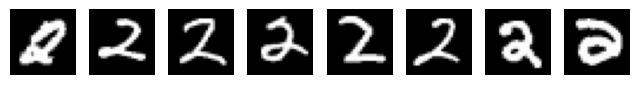

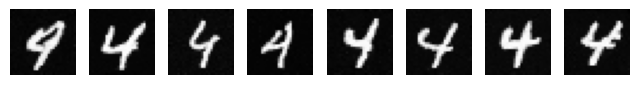

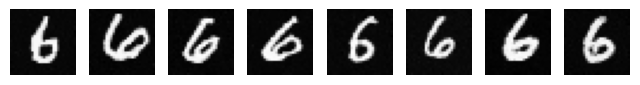

barycentre samples (started from marginal 0)


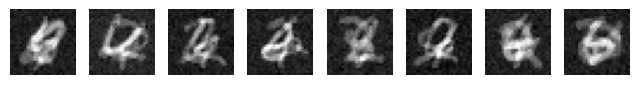

new barycentre samples (clean and noised)


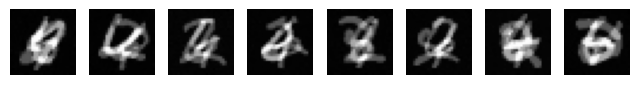

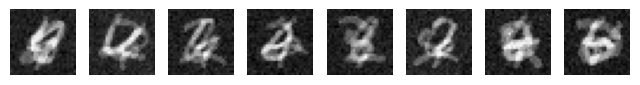

In [8]:
key = jax.random.PRNGKey(0)
num_steps = 50
num_samples = 8

start_idx = 0

IMF_idx = -1

bm_lst = all_bms_lst[IMF_idx]
states_lst = all_states_lst[IMF_idx]

coupling_samples, trajs = baryDSBM.get_multi_coupling(key, bm_lst, states_lst, num_steps=num_steps, num_samples=num_samples, start_idx=start_idx, return_trajs=True)

new_nu_samples = jnp.einsum('n...,n->...', coupling_samples[:-1, :], weights)
noised_new_nu_samples = new_nu_samples + jax.random.normal(key, (num_samples, *shape)) * sigma

print(f'marginal samples (started from marginal {start_idx})')
plot_mnist(coupling_samples[0], n=8)
plot_mnist(coupling_samples[1], n=8)
plot_mnist(coupling_samples[2], n=8)

print(f'barycentre samples (started from marginal {start_idx})')
plot_mnist(coupling_samples[-1], n=8)

print(f'new barycentre samples (clean and noised)')
plot_mnist(new_nu_samples, n=8)
plot_mnist(noised_new_nu_samples, n=8)